# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [5]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [6]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [7]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [15]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [16]:
# TODO: In model.py, implement compute_loss_and_gradients function
print(train_X[:2].shape)
print(train_y[:2])



model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])
print("*"*60)
print(train_X[:2])
# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

(2, 3072)
[9 9]
n_input 3072
n_output 10
hidden_layer_size 3
************************************************************
[[-0.08975373 -0.03568431  0.08994824 ... -0.12654745 -0.03998549
   0.09710392]
 [ 0.01612863  0.01921765  0.05465412 ... -0.15007686 -0.13410314
  -0.10681765]]
Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [17]:
%%time
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

n_input 3072
n_output 10
hidden_layer_size 3
Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!
CPU times: user 35.8 s, sys: 13.1 s, total: 48.9 s
Wall time: 30.7 s


Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [19]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
print(train_y[:30])
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 
#model_with_reg.predict(train_X[:30])

[9 9 2 1 7 1 3 5 3 6 4 2 9 1 0 7 2 1 4 7 5 9 5 3 8 9 6 6 5 1]


0.06666666666666667

# Допишем код для процесса тренировки

In [28]:
# model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1-3)
# dataset = Dataset(train_X, train_y, val_X, val_y)
# #trainer = Trainer(model, dataset, SGD())
# trainer = Trainer(model, dataset, SGD(), learning_rate=1e-2)


model = TwoLayerNet(hidden_layer_size = 100, n_input = train_X.shape[1], n_output = 10, reg = 0.001)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down and train and val accuracy go up for every epoch
loss_history, train_history, val_history = trainer.fit()

n_input 3072
n_output 10
hidden_layer_size 100
Loss: 2.219591, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.294364, Train accuracy: 0.273889, val accuracy: 0.277000
Loss: 1.474355, Train accuracy: 0.379778, val accuracy: 0.368000
Loss: 1.588909, Train accuracy: 0.460111, val accuracy: 0.438000
Loss: 1.527245, Train accuracy: 0.516667, val accuracy: 0.489000
Loss: 1.629716, Train accuracy: 0.529667, val accuracy: 0.511000
Loss: 1.383967, Train accuracy: 0.530000, val accuracy: 0.513000
Loss: 1.580411, Train accuracy: 0.507222, val accuracy: 0.476000
Loss: 2.353345, Train accuracy: 0.507222, val accuracy: 0.486000
Loss: 1.274851, Train accuracy: 0.549444, val accuracy: 0.540000
Loss: 1.542667, Train accuracy: 0.539222, val accuracy: 0.535000
Loss: 1.293627, Train accuracy: 0.579556, val accuracy: 0.566000
Loss: 1.443972, Train accuracy: 0.567111, val accuracy: 0.543000
Loss: 1.259294, Train accuracy: 0.553556, val accuracy: 0.537000
Loss: 1.378062, Train accuracy: 0.580556, v

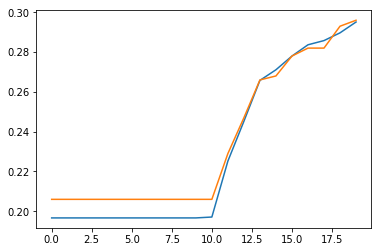

In [40]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [37]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

#model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
#dataset = Dataset(train_X, train_y, val_X, val_y)
#trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

model = TwoLayerNet(hidden_layer_size = 100, n_input = train_X.shape[1], n_output = 10, reg = 0.001)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, learning_rate_decay=0.99)


initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

n_input 3072
n_output 10
hidden_layer_size 100
Loss: 2.270483, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 1.977249, Train accuracy: 0.296556, val accuracy: 0.308000
Loss: 1.859580, Train accuracy: 0.392333, val accuracy: 0.397000
Loss: 1.692940, Train accuracy: 0.457889, val accuracy: 0.467000
Loss: 1.377178, Train accuracy: 0.504667, val accuracy: 0.493000
Loss: 1.860862, Train accuracy: 0.503222, val accuracy: 0.494000
Loss: 1.232431, Train accuracy: 0.538000, val accuracy: 0.509000
Loss: 1.436310, Train accuracy: 0.546444, val accuracy: 0.526000
Loss: 1.004136, Train accuracy: 0.543778, val accuracy: 0.540000
Loss: 1.260936, Train accuracy: 0.543778, val accuracy: 0.543000
Loss: 1.581981, Train accuracy: 0.566667, val accuracy: 0.555000
Loss: 1.799937, Train accuracy: 0.544778, val accuracy: 0.524000
Loss: 1.668248, Train accuracy: 0.574444, val accuracy: 0.559000
Loss: 1.556249, Train accuracy: 0.567333, val accuracy: 0.558000
Loss: 1.782776, Train accuracy: 0.589000, v

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [39]:
# TODO: Implement MomentumSGD.update function in optim.py

# model = TwoLayerNet(hidden_layer_size = 100, n_input = train_X.shape[1], n_output = 10, reg = 0.001)
# dataset = Dataset(train_X, train_y, val_X, val_y)
# trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, learning_rate_decay=0.99)




model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0.001)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-3, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

n_input 3072
n_output 10
hidden_layer_size 100
Loss: 2.240555, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.235754, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.174535, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.335046, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.307133, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.222573, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.207723, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.421446, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.200580, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.263781, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.121391, Train accuracy: 0.197111, val accuracy: 0.206000
Loss: 2.277801, Train accuracy: 0.225222, val accuracy: 0.229000
Loss: 2.255960, Train accuracy: 0.245222, val accuracy: 0.247000
Loss: 2.161333, Train accuracy: 0.265778, val accuracy: 0.266000
Loss: 1.795552, Train accuracy: 0.271111, v

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [57]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0.01)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)


#model = TwoLayerNet(100, 3072, 10, reg = 0.001)
#dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
#trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

n_input 3072
n_output 10
hidden_layer_size 100
Loss: 2.314963, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.294254, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.289132, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.308178, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.268752, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.306423, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.211330, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.135544, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.221152, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.152039, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.098917, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.299753, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.721297, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.035154, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.178121, Train accuracy: 0.400000, v

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [60]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 0.1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

n_input 3072
n_output 10
hidden_layer_size 100
Loss: 2.317259, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.313212, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.298604, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.269913, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.286836, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.264099, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.262226, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.344336, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.292329, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.167753, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.191639, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.178633, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 1.995397, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.320156, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.678529, Train accuracy: 0.400000, v

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **40%** на validation set.

In [65]:
learning_rates = [1e-2]
reg_strengths = [1e-3]
learning_rate_decay = [0.99]
hidden_layer_sizes = [256]
num_epochs = [200]
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []
best_learning_rate = 0
best_reg_strength = 0
best_hidden_layer_size = 0
best_num_epoch = 0

for learning_rate in learning_rates:
    for reg_strength in reg_strengths:
        for hidden_layer_size in hidden_layer_sizes:
            for num_epoch in num_epochs:
                #model = TwoLayerNet(hidden_layer_size, 3072, 10, reg = reg_strength)
                model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, reg = reg_strength)
                dataset = Dataset(train_X, train_y, val_X, val_y)
                trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=learning_rate, num_epochs=num_epoch, batch_size=batch_size)

                loss_history, train_history, val_history = trainer.fit()
                
                if best_classifier == None:
                    best_classifier = model
                    best_val_accuracy = val_history[-1]
                
                if best_val_accuracy<best_val_accuracy:
                    best_classifier = model
                    best_val_accuracy = val_history[-1]
                    best_learning_rate = learning_rate
                    best_reg_strength = reg_strength
                    best_hidden_layer_size = hidden_layer_size
                    best_num_epoch = num_epoch
                print('next')

print('best validation accuracy achieved: %f' % best_val_accuracy)

n_input 3072
n_output 10
hidden_layer_size 256
Loss: 2.329177, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.270695, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.080275, Train accuracy: 0.202889, val accuracy: 0.209000
Loss: 2.100074, Train accuracy: 0.278444, val accuracy: 0.282000
Loss: 1.673857, Train accuracy: 0.337778, val accuracy: 0.336000
Loss: 1.625877, Train accuracy: 0.427333, val accuracy: 0.418000
Loss: 1.765355, Train accuracy: 0.511889, val accuracy: 0.513000
Loss: 1.308409, Train accuracy: 0.563556, val accuracy: 0.559000
Loss: 1.558079, Train accuracy: 0.611556, val accuracy: 0.600000
Loss: 1.224174, Train accuracy: 0.643556, val accuracy: 0.643000
Loss: 1.279012, Train accuracy: 0.660111, val accuracy: 0.644000
Loss: 1.246283, Train accuracy: 0.684556, val accuracy: 0.669000
Loss: 1.557325, Train accuracy: 0.695111, val accuracy: 0.678000
Loss: 1.058458, Train accuracy: 0.716000, val accuracy: 0.679000
Loss: 0.958246, Train accuracy: 0.718222, v

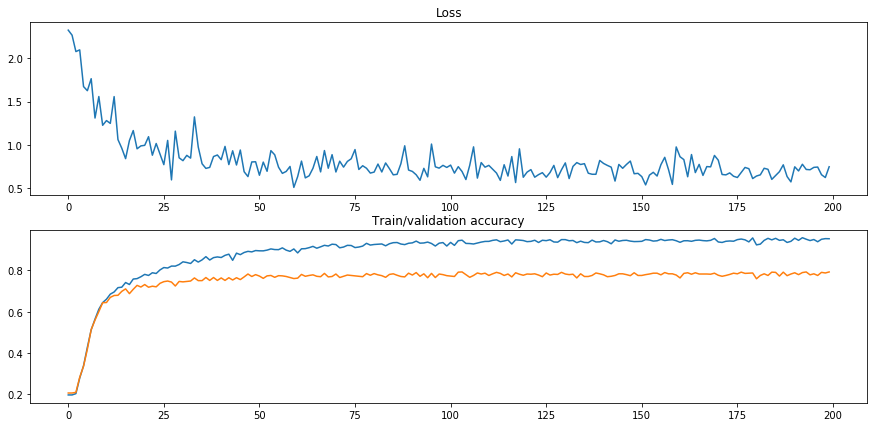

In [67]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [68]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.769000
